# Librerias 

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import comb
import pandas as pd

# Inciso A 

# Inciso B

# Inciso C

Rectángulo verdadero (índices): (10, 30, 15, 40)
Rectángulo aprendido: (9, 30, 16, 40)
Error empírico L_S(h): 0.0033
Error verdadero L_D(h): 0.0280


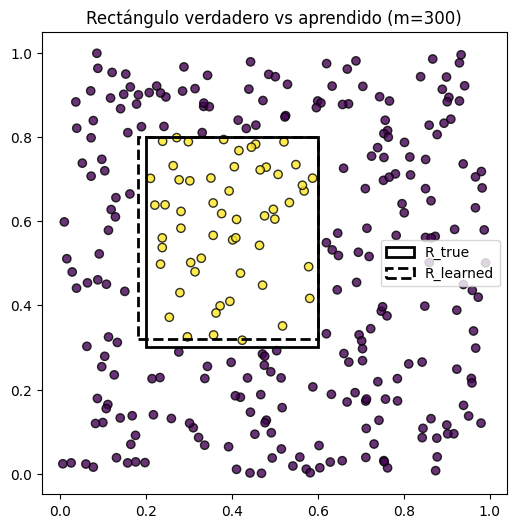

m=50 -> L_D(h) mediana: 0.0790
m=100 -> L_D(h) mediana: 0.0210
m=200 -> L_D(h) mediana: 0.0120
m=300 -> L_D(h) mediana: 0.0080
m=500 -> L_D(h) mediana: 0.0070
m=1000 -> L_D(h) mediana: 0.0000


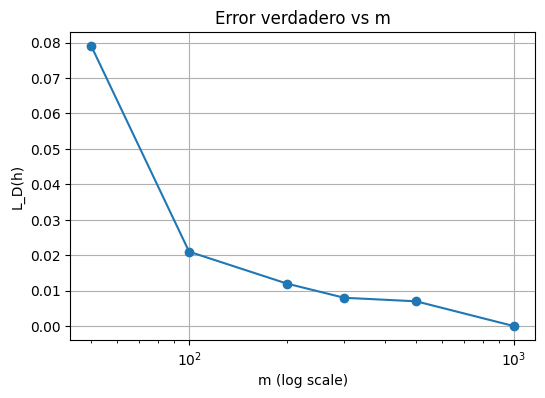

Para ε=0.05, δ=0.05: m >= 344.3
Para ε=0.02, δ=0.05: m >= 860.9
Para ε=0.01, δ=0.05: m >= 1721.7


In [ ]:

# ----------------------
# Parámetros globales
# ----------------------
N = 50                 # grilla en cada eje (valores enteros 0..N)
BITS = int(np.ceil(np.log2(N+1)))
genome_len = 4 * BITS

true_rect_indices = (10, 30, 15, 40)   # rectángulo verdadero en la grilla [0..N]
a_true, b_true, c_true, d_true = true_rect_indices

def f_true(points):
    """Función verdadera del rectángulo"""
    x = points[:,0]; y = points[:,1]
    return ((a_true/N <= x) & (x <= b_true/N) &
            (c_true/N <= y) & (y <= d_true/N)).astype(int)

# Codificación y decodificación binaria
def encode_rect(a,b,c,d):
    return format(a, f'0{BITS}b') + format(b, f'0{BITS}b') + \
           format(c, f'0{BITS}b') + format(d, f'0{BITS}b')

def decode_rect(genome):
    vals = [int(genome[i*BITS:(i+1)*BITS], 2) for i in range(4)]
    a,b = sorted(vals[:2]); c,d = sorted(vals[2:])
    a = max(0, min(N, a)); b = max(0, min(N, b))
    c = max(0, min(N, c)); d = max(0, min(N, d))
    return a,b,c,d

def fitness_of_genome(genome, points, labels):
    a,b,c,d = decode_rect(genome)
    preds = ((a/N <= points[:,0]) & (points[:,0] <= b/N) &
             (c/N <= points[:,1]) & (points[:,1] <= d/N)).astype(int)
    error = np.mean(preds != labels)
    return 1.0 - error

# Operadores genéticos
def tournament_selection(population, fitnesses, k=2):
    idxs = random.sample(range(len(population)), k)
    best_idx = max(idxs, key=lambda i: fitnesses[i])
    return population[best_idx]

def one_point_crossover(p1, p2):
    pt = random.randint(1, genome_len-1)
    return p1[:pt] + p2[pt:], p2[:pt] + p1[pt:]

def mutate(genome, rate):
    g = list(genome)
    for i in range(len(g)):
        if random.random() < rate:
            g[i] = '1' if g[i] == '0' else '0'
    return "".join(g)

def run_ga(points, labels, pop_size=50, generations=80,
           elite_size=2, mutation_rate=0.01, seed=None):
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    population = ["".join(random.choice("01") for _ in range(genome_len))
                  for _ in range(pop_size)]
    best_history = []
    for gen in range(generations):
        fitnesses = [fitness_of_genome(g, points, labels) for g in population]
        best_idx = int(np.argmax(fitnesses))
        best_history.append(fitnesses[best_idx])
        sorted_idx = sorted(range(pop_size), key=lambda i: fitnesses[i], reverse=True)
        new_pop = [population[i] for i in sorted_idx[:elite_size]]
        while len(new_pop) < pop_size:
            p1 = tournament_selection(population, fitnesses, k=2)
            p2 = tournament_selection(population, fitnesses, k=2)
            c1, c2 = one_point_crossover(p1, p2)
            c1 = mutate(c1, mutation_rate)
            c2 = mutate(c2, mutation_rate)
            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)
        population = new_pop[:pop_size]
    final_fits = [fitness_of_genome(g, points, labels) for g in population]
    best_idx = int(np.argmax(final_fits))
    return population[best_idx], best_history

def empirical_error(genome, points, labels):
    a,b,c,d = decode_rect(genome)
    preds = ((a/N <= points[:,0]) & (points[:,0] <= b/N) &
             (c/N <= points[:,1]) & (points[:,1] <= d/N)).astype(int)
    return np.mean(preds != labels)

def true_error(genome, m_test=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    test_pts = np.random.rand(m_test, 2)
    true_lbls = f_true(test_pts)
    a,b,c,d = decode_rect(genome)
    preds = ((a/N <= test_pts[:,0]) & (test_pts[:,0] <= b/N) &
             (c/N <= test_pts[:,1]) & (test_pts[:,1] <= d/N)).astype(int)
    return np.mean(preds != true_lbls)

def experiment_for_m(m, runs=21, pop_size=60, generations=100,
                     elite_size=2, mutation_rate=0.01):
    points = np.random.rand(m, 2)
    labels = f_true(points)
    results = []
    histories = []
    seeds = [random.randint(0,10**9) for _ in range(runs)]
    for i in range(runs):
        g, hist = run_ga(points, labels, pop_size, generations,
                         elite_size, mutation_rate, seed=seeds[i])
        emp_err = empirical_error(g, points, labels)
        t_err = true_error(g, m_test=1000, seed=seeds[i]+1)
        results.append({'genome': g, 'emp_err': emp_err, 'true_err': t_err})
        histories.append(hist)
    results_sorted = sorted(results, key=lambda r: r['emp_err'])
    median_result = results_sorted[len(results_sorted)//2]
    return points, labels, median_result, histories

# ----------------------
# Ejemplo: correr para m=300
# ----------------------
m0 = 300
points, labels, median_result, histories = experiment_for_m(m0)

median_genome = median_result['genome']
a_learn, b_learn, c_learn, d_learn = decode_rect(median_genome)

print("Rectángulo verdadero (índices):", true_rect_indices)
print("Rectángulo aprendido:", (a_learn, b_learn, c_learn, d_learn))
print(f"Error empírico L_S(h): {median_result['emp_err']:.4f}")
print(f"Error verdadero L_D(h): {median_result['true_err']:.4f}")

# Visualización nube de puntos y rectángulos
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], c=labels, edgecolor='k', alpha=0.8)
ax = plt.gca()
rect_true = plt.Rectangle((a_true/N, c_true/N), (b_true-a_true)/N, (d_true-c_true)/N,
                          fill=False, linewidth=2, label='R_true')
ax.add_patch(rect_true)
rect_learn = plt.Rectangle((a_learn/N, c_learn/N), (b_learn-a_learn)/N, (d_learn-c_learn)/N,
                           fill=False, linewidth=2, label='R_learned', linestyle='--')
ax.add_patch(rect_learn)
plt.title("Rectángulo verdadero vs aprendido (m=300)")
plt.legend(); plt.show()

# ----------------------
# Repetir para varios m
# ----------------------
m_values = [50, 100, 200, 300, 500, 1000]
median_true_errors = []
for m in m_values:
    errs = []
    for _ in range(5):
        _, _, median_result, _ = experiment_for_m(m, runs=7)
        errs.append(median_result['true_err'])
    median_true_errors.append(np.median(errs))
    print(f"m={m} -> L_D(h) mediana: {median_true_errors[-1]:.4f}")

plt.figure(figsize=(6,4))
plt.plot(m_values, median_true_errors, marker='o')
plt.xscale('log')
plt.title("Error verdadero vs m")
plt.xlabel("m (log scale)"); plt.ylabel("L_D(h)")
plt.grid(True); plt.show()

# ----------------------
# Comparación con PAC
# ----------------------
H_size = comb(N,2)**2
epsilons = [0.05, 0.02, 0.01]
delta = 0.05
for eps in epsilons:
    bound = (1/eps)*np.log(H_size/delta)
    print(f"Para ε={eps}, δ={delta}: m >= {bound:.1f}")